## API Class

In [27]:
#-*- coding=utf-8 -*-
from datetime import datetime
import hashlib

class Gemtek_restful_api:
    def __init__(self, URL, api_key, api_secret, macID, index = 0, limit = 10, start_time = 0):
        self.URL = URL
        self.api_key = api_key
        self.api_secret = api_secret
        self.macID = macID
        self.index = index
        self.limit = limit
        self.start_time = start_time
        self.end_time = 0
        self.time = str(int(time.time()))
        self.api_token = hashlib.sha1((self.api_secret + self.time).encode('utf-8')).hexdigest()
        self.payload = {
            "index": self.index,
            "mac" : self.macID,
            "api_key" : self.api_key,
            "api_token" : self.api_token,
            "time" : self.time,
        }
        self.jsonData = None
        self.request_OK = None
        self.jsonDataLength = None
        
        if len(macID) != 12:
            print("mac address is ilegal !!")
        
    def set_query_index(self, index ):
        self.index = index
        self.payload["index"] = self.index

    def set_query_limit(self, limit ):
        self.limit = limit
        self.payload["limit"] = self.limit
        
    def set_query_start_time(self, start_time = 0):
        self.start_time = start_time  
        self.payload["start_time"] = self.start_time

    def set_query_end_time(self, end_time):
        self.end_time = end_time
        self.payload["end_time"] = self.end_time
        
    def get_query_start_time(self):
        return self.start_time

    def get_query_end_time(self):
        return self.end_time
    
    def set_query_mac(self, macID):
        self.macID = macID  
        self.payload["mac"] = self.macID
        
    def print_API_parameter(self):
        print("------------- RESTful API parameter --------------")
        print("mac: ", self.macID)
        print("api_key: ", self.api_key)
        print("api_secret: ", self.api_secret)
        print("unix_time: ", self.time)
        print("api_token: ", self.api_token)
        print("index: ", self.index, "limit: ", self.limit)
        print("Payload:", self.payload)
        print("--------------------------------------------------\n")
        
    def get_query_data(self):    
        req = requests.post(self.URL, json = self.payload)
        self.jsonData = req.json()
#         print("jsonData", self.jsonData)
        self.jsonDataLength = self.jsonData['value']['total']
        server_ReturnCode = self.jsonData['status']['code']
        server_ReturnMsg = self.jsonData['status']['message']
        
        if (server_ReturnCode == 1200):
            self.request_OK = True
        else:
            self.request_OK = False
        
#         print("------------- Request Status ---------------------")
#         print("Request URL: ", req.url)
#         print("Server return code: ",server_ReturnCode, ", Msg :", server_ReturnMsg)
#         print("Packet Length: ", self.jsonDataLength)
#         print("--------------------------------------------------\n")
     
        return self.jsonData
    
    def update_new_api_token(self):    
        self.time = str(int(time.time()))
        self.api_token = hashlib.sha1((self.api_secret + self.time).encode('utf-8')).hexdigest()
        self.payload["time"] = self.time
        self.payload["api_token"] = self.api_token
    


In [5]:
# lenth = 100
# test_api = Gemtek_restful_api(URL, api_key, api_secret, mac_address1, limit = lenth)
# test_api.print_API_parameter()
# query_JsonData = test_api.get_query_data()

In [6]:
def check_file_path_exist(csvName):
    if not os.path.exists(os.path.dirname(csvName)):
        try:
            os.makedirs(os.path.dirname(csvName))
        except OSError as exc: # Guard against race condition
            if exc.errno != errno.EEXIST:
                raise
                
def get_datetime_from_timeString(date_string):
    date_string = date_string.replace('T',' ').replace('Z','')
    datetime_object = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S.%f')
    return datetime_object

def get_two_datetime_delta(datetime_object1 , datetime_object2):
    datetime_delta   = datetime_object2 - datetime_object1
    return datetime_delta.total_seconds()

In [7]:
def byteToMagData(Low_byte, High_byte):
    value = int(Low_byte.encode(), 16) + int(High_byte.encode(), 16) * 256
    return twos_comp(value, 16)

def twos_comp(val, bits):
    """compute the 2's complement of int value val"""
    if (val & (1 << (bits - 1))) != 0: # if sign bit is set e.g., 8bit: 128-255
        val = val - (1 << bits)        # compute negative value
    return val 

def getPraseTargetData(Data):
    prase_data = Data['value']['hits']
    prase_data_from_json = []
    latency_time_list = list()
    create_time_list  = list()
    # 'Asia/Taipei' LMT+8:06:00 STD
    TPE_UTC_offset = 60*60*8 
    
    # columes in data frame
    prase_data_columes = ['_id', '_index', 'mac','create_at_time','recv_at_time','frameCnt', 'data',
                          'company','road','slot_num','gwip','rssi','snr',
                          "timestamp","latency_time","magX", "magY", "magZ","mag_len" ,"magT"]

    # get data by list
    for each in prase_data:
        fullData = []
        pakcetHeader = "fcffff07"
        packetByte = []
        
        fullData = [ each['_id'], each['_index'], each['_source']['macAddr'],
             each['_source']['create_at'], each['_source']['recv'], each['_source']['frameCnt'],
             each['_source']['data'], 
             each['_source']['extra']['company'],  each['_source']['extra']['road'], 
             each['_source']['extra']['slot_num'], each['_source']['gwip'],
             # each['_source']['dataParse']['voltage'], each['_source']['dataParse']['lowBattery'],
             each['_source']['rssi'], each['_source']['snr']
        ]
        
        create_time = get_datetime_from_timeString( each['_source']['create_at'])
        recv_time   = get_datetime_from_timeString( each['_source']['recv'] )
        latency_time = get_two_datetime_delta( recv_time , create_time )
        
        # get high/ low byte
        packetMagData = each['_source']['data']
        
#         if packetMagData.find(pakcetHeader) != -1:
#             index = [i for i in range(len(packetMagData)) if i % 2 == 0]   
#             for each in index:
#                 packetByte.append(packetMagData[each:each+2])
# #             print("packet Byte: ", packetByte)
#         else:
#             print("packet header error")
        
        
        index = [i for i in range(len(packetMagData)) if i % 2 == 0]   
        for each in index:
            packetByte.append(packetMagData[each:each+2])
        
#         print("packet Byte: ", packetByte)
        
        magX = byteToMagData(packetByte[-7], packetByte[-6])
        magY = byteToMagData(packetByte[-5], packetByte[-4])
        magZ = byteToMagData(packetByte[-3], packetByte[-2])
        magT = byteToMagData(packetByte[-1], '00')
        maglen = (magX**2 + magY**2 + magZ**2)**(0.5)

        fullData.extend([recv_time.timestamp() + TPE_UTC_offset, latency_time, magX, magY, magZ, maglen, magT])
#         print("Data:", fullData)
        prase_data_from_json.append(fullData)
    return pd.DataFrame(prase_data_from_json, columns=prase_data_columes) 


In [8]:
import time
from datetime import datetime

current_time_obj = time.time()
current_datetime_obj = datetime.fromtimestamp(current_time_obj)
current_time = int(current_time_obj)
print("current unix time (sec): ",current_time)


current_milli_time = lambda: int(round(time.time() * 1000))
print("current unix time (ms): ",current_milli_time())


current unix time (sec):  1502856126
current unix time (ms):  1502856126038


In [93]:
#-*- coding=utf-8 -*-
import os, sys, errno
import requests
import json
import time
import hashlib
import pandas as pd
from datetime import datetime
import threading

URL = "https://s5.securepilot.com/parking/v1/query_record"
api_key = "PARK-eMPpua7y17"
api_secret = "2PHIAGI5qv5IhMGZ56iy"
folderNmae = os.getcwd() + '/0816_MatrixALL/'
testName = folderNmae + ''

# mac_gemtek = "101a"
# mac_address1 = mac_gemtek + "0d0100ab"
# mac_address_test = mac_gemtek + "0d0100cc"

mac_gemtek = "101a"
mac_list = ["0d0100d9","0d0100dc","0d0100b5",
            "0d0100b8","0d01019a","0d0100c0",
            "0d0100e4","0d0100cb","None",
            "0d0100a3","0d0101e4","0d0100cc",
            "0d0100da","0d010119","0d0101eb" ]
mac_query_list = [mac_gemtek + f for f in  mac_list]

matrix_node = ["L1","M1", "R1", 
                "L2","M2", "R2",
                "L3","M3", "R3",
                "L4","M4", "R4",
                "L5","M5", "R5"]

mac_query_dict = dict(zip(matrix_node, mac_query_list))

######################### Query loop ####################   
def query_AWS_data(dfcsv, api, csvName, enable_threading = False ):
    if enable_threading == True:
        threading.Timer(10.0, query_AWS_data).start()
    
    data_send_interval = 3
    timestamp_sec_to_ms = 1000
    retry_counter = 5
    # new timestamp to query
    query_start_timestamp = api.get_query_start_time()
    csv_start_timestamp = int(dfcsv.timestamp[0] * timestamp_sec_to_ms)
    dfCombineCSV = dfcsv
    pre_interval = 0

    while query_start_timestamp < csv_start_timestamp:
        
        api.set_query_end_time(int(csv_start_timestamp))
        interval = int((csv_start_timestamp - query_start_timestamp)/data_send_interval /timestamp_sec_to_ms) + 1
        api.set_query_limit(interval)
        
#         print("csv query timestamp, start:", api.get_query_start_time(), " end: ", csv_start_timestamp,
#              "limit", interval)
        query_JsonData = api.get_query_data()
        if(api.request_OK):
            dfjson = getPraseTargetData(query_JsonData)
            dfCombineCSV = dfCombineCSV.append(dfjson, ignore_index=True)  
            dfCombineCSV = dfCombineCSV.drop_duplicates(['recv_at_time','create_at_time','gwip'])
            dfCombineCSV = dfCombineCSV.sort_values(['recv_at_time', 'frameCnt'], ascending=[True, True])
            dfCombineCSV.to_csv(csvName, encoding='utf_8_sig')
            csv_start_timestamp = int(dfCombineCSV.timestamp[0] * timestamp_sec_to_ms)
#             print("DB length:",len(dfCombineCSV))
        else:
            print("Server Request Fail")

        if (interval == pre_interval):
            retry += 1
        else:
            retry = 0
        
        pre_interval = interval
        
        if (retry >= retry_counter):
            print("DB length:",len(dfCombineCSV))
            return None
        
#         # interval 
#         if (interval <= data_send_interval):
#             print("DB length:",len(dfCombineCSV))
#             return None
        


    
########### main ###############
query_time = 0
offset = 0
ex_start_time = 1502342323000 + offset
ex_end_time = 1502355794000 + offset

data_send_interval = 3
timestamp_sec_to_ms = 1000
ex_interval = int((ex_end_time - ex_start_time) / data_send_interval / timestamp_sec_to_ms) + 1

########## Single Node Prase ##################
# query_list_key = "R1"
# mac_query = mac_query_dict[query_list_key]
# parking_api = Gemtek_restful_api(URL, api_key, api_secret, mac_query, index = 0 , limit = 20)

# parking_api.set_query_mac(mac_query)
# parking_api.set_query_start_time(ex_start_time)
# parking_api.set_query_end_time(ex_end_time)
# parking_api.set_query_limit(ex_interval)
# parking_api.print_API_parameter()

# NodeName = mac_query
# csvFileName = testName + query_list_key + '_Node_' + NodeName + '.csv'
# csvNewFileName = testName + query_list_key + '_Node_' + NodeName + '_new.csv'
# #     csvFileName = testName + 'Node_' + NodeName + '_' + timeName + '_' + str(current_time) + '.csv'
# check_file_path_exist(csvFileName)
# check_file_path_exist(csvNewFileName) 
# print("\n\n-------------- mac ID:", mac_query, "----------------")

# # check if node csv exist, if not, get json data from server

# try:
#     dfcsv = pd.read_csv(csvFileName, encoding='utf_8_sig', index_col=0)   
#     query_AWS_data(dfcsv, parking_api, csvFileName, enable_threading = False)
#     query_time += 1
#     print("query_time: ", query_time )
# except:
#     query_JsonData = parking_api.get_query_data()
#     if query_JsonData['value']['total'] == 0:
#         print("Query ok, but this packet don't contain data", query_JsonData)
#     else:
#         dfcsv = getPraseTargetData(query_JsonData)
#         dfcsv.to_csv(csvFileName)
#         print("csv file doesn't exist, try to create")
#         query_AWS_data(dfcsv, parking_api, csvFileName, enable_threading = False)
#         query_time += 1
#         print("query_time: ", query_time )

########## Multiple Node Prase ##################

for query_list_key in mac_query_dict:
    mac_query = mac_query_dict[query_list_key]
    parking_api = Gemtek_restful_api(URL, api_key, api_secret, mac_query, index = 0 , limit = 20)

    parking_api.set_query_mac(mac_query)
    parking_api.set_query_start_time(ex_start_time)
    parking_api.set_query_end_time(ex_end_time)
    parking_api.set_query_limit(ex_interval)
#     parking_api.print_API_parameter()

    NodeName = mac_query
    csvFileName = testName + query_list_key + '_Node_' + NodeName + '.csv'
    csvNewFileName = testName  + query_list_key + '_Node_'+ NodeName + '_new.csv'
    #     csvFileName = testName + 'Node_' + NodeName + '_' + timeName + '_' + str(current_time) + '.csv'
    check_file_path_exist(csvFileName)
    check_file_path_exist(csvNewFileName) 
    print("\n\n-------------- mac ID:", mac_query, "----------------")

    # check if node csv exist, if not, get json data from server

    try:
        dfcsv = pd.read_csv(csvFileName, encoding='utf_8_sig', index_col=0)   
        query_AWS_data(dfcsv, parking_api, csvFileName, enable_threading = False)
        query_time += 1
        print("query_time: ", query_time )
    except:
        query_JsonData = parking_api.get_query_data()
        if query_JsonData['value']['total'] == 0:
            print("Query ok, but this packet don't contain data", query_JsonData)
        else:
            dfcsv = getPraseTargetData(query_JsonData)
            dfcsv.to_csv(csvFileName, encoding='utf_8_sig')
            print("csv file doesn't exist, try to create")
            query_AWS_data(dfcsv, parking_api, csvFileName, enable_threading = False)
            query_time += 1
            print("query_time: ", query_time )



-------------- mac ID: 101a0d0100d9 ----------------
DB length: 2878
query_time:  1


-------------- mac ID: 101a0d0100dc ----------------
DB length: 2778
query_time:  2


-------------- mac ID: 101a0d0100b5 ----------------
DB length: 2339
query_time:  3


-------------- mac ID: 101a0d0100b8 ----------------
DB length: 4954
query_time:  4


-------------- mac ID: 101a0d01019a ----------------
DB length: 2867
query_time:  5


-------------- mac ID: 101a0d0100c0 ----------------
DB length: 3946
query_time:  6


-------------- mac ID: 101a0d0100e4 ----------------
query_time:  7


-------------- mac ID: 101a0d0100cb ----------------
query_time:  8
mac address is ilegal !!


-------------- mac ID: 101aNone ----------------
Query ok, but this packet don't contain data {'status': {'code': 1200, 'message': 'Command succeeded'}, 'value': {'total': 0, 'max_score': None, 'hits': []}}


-------------- mac ID: 101a0d0100a3 ----------------
query_time:  9


-------------- mac ID: 101a0d0101e4 --

## Data prasing 
 1. lattency

In [75]:
#-*- coding=utf-8 -*-
import requests
import json
import time
import hashlib
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt 
import matplotlib.dates as dates
%matplotlib inline

df = pd.read_csv(csvFileName, encoding='utf_8_sig')
df['date'] = pd.to_datetime(df['timestamp'],unit='s')

count = df['date']
magX = df.magX
magY = df.magY
magZ = df.magZ
magT = df.magT

plt.figure()
plt.plot(count, magX, label='magX')
plt.plot(count, magY, label='magY')
plt.plot(count, magZ, label='magZ')
plt.xlabel('Time')
plt.ylabel('Mag Value')
plt.title('Mag data Plot \n ')
plt.legend()
plt.show()

# df2 = pd.DataFrame(np.random.rand(10, 4), columns=['magX', 'magX', 'magX', 'magX'])
# plt.figure(); df2.plot();

SyntaxError: invalid syntax (<ipython-input-75-67367726c2c5>, line 20)

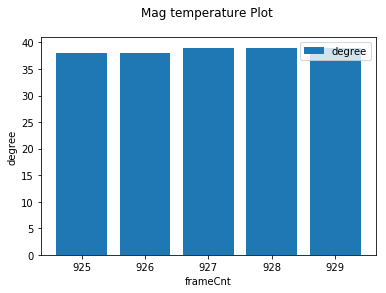

In [741]:
plt.figure()
plt.bar(count, magT, label='degree')
plt.xlabel('frameCnt')
plt.ylabel('degree')
plt.title('Mag temperature Plot \n ')
plt.legend()
plt.show()

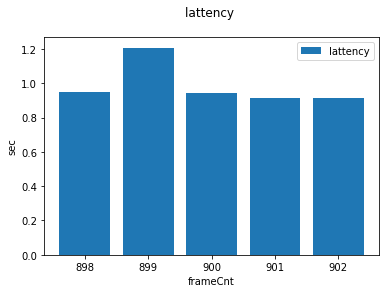

In [718]:
lattency = df.latency_time

plt.figure()
plt.bar(count, lattency, label='lattency')
plt.xlabel('frameCnt')
plt.ylabel('sec')
plt.title('lattency \n ')
plt.legend()
plt.show()

In [101]:
csvNmae = os.getcwd() + '/0816_MatrixALL/experiment_item/20170810_Gemtek_Matrix.xlsx'
xls = pd.ExcelFile(csvNmae)
df_Ford = xls.parse('Ford')
df_ColtPlus = xls.parse('ColtPlus')
df_RV = xls.parse('RV')

In [102]:
df_Ford[]

,Experiment_type,Car_type,start_time,end_time,duration (second),data points,start_time.1,end_time.1
0,EnV,Ford,1502351602,1502351902,300,100.000000,2017-08-10 15:53:22,2017-08-10 15:58:22
1,F1,Ford,1502352306,1502352413,107,35.666667,2017-08-10 16:05:06,2017-08-10 16:06:53
2,B1,Ford,1502352440,1502352556,116,38.666667,2017-08-10 16:07:20,2017-08-10 16:09:16
3,F2,Ford,1502352556,1502352644,88,29.333333,2017-08-10 16:09:16,2017-08-10 16:10:44
4,B2,Ford,1502352644,1502352726,82,27.333333,2017-08-10 16:10:44,2017-08-10 16:12:06
5,R70,Ford,1502352761,1502352835,74,24.666667,2017-08-10 16:12:41,2017-08-10 16:13:55
6,R50,Ford,1502353020,1502353112,92,30.666667,2017-08-10 16:17:00,2017-08-10 16:18:32
7,Back70,Ford,1502353274,1502353377,103,34.333333,2017-08-10 16:21:14,2017-08-10 16:22:57
8,Back50,Ford,1502353377,1502353456,79,26.333333,2017-08-10 16:22:57,2017-08-10 16:24:16
9,Front70,Ford,1502351902,1502352166,264,88.000000,2017-08-10 15:58:22,2017-08-10 16:02:46


In [105]:
folderNmae = os.getcwd() + '/0816_MatrixALL/'
carName = df_Ford["Car_type"][0]
experiemntName = df_Ford["Experiment_type"][index]
query_start_time = df_Ford["start_time"][index]
query_end_time

In [106]:
carName

'Ford'